In [2]:
from fastai.vision.all import *
import fastai
import timm
import torch
from wwf.vision import timm

In [3]:
torch.cuda.set_device(0)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs224wwf',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [13]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0014454397605732083)

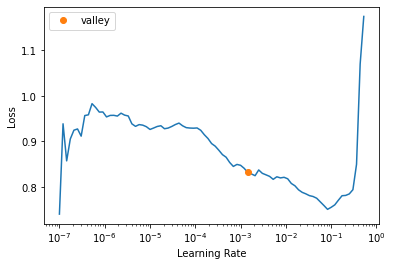

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.659123,0.332076,0.789744,0.808743,0.758974,0.783069,0.862153,01:08
1,0.550727,0.311975,0.812820,0.799020,0.835897,0.817043,0.887867,01:07
2,0.455930,0.223651,0.805128,0.881410,0.705128,0.783476,0.886880,01:07


Better model found at epoch 0 with f1_score value: 0.783068783068783.


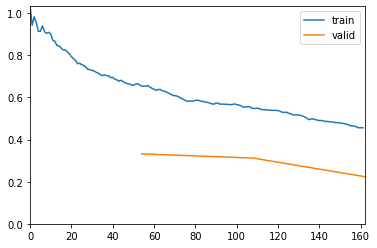

Better model found at epoch 1 with f1_score value: 0.8170426065162908.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.428783,0.222251,0.829487,0.864023,0.782051,0.820996,0.906548,01:13
1,0.382234,0.211900,0.825641,0.875740,0.758974,0.813187,0.911762,01:12
2,0.364551,0.213726,0.823077,0.896226,0.730769,0.805085,0.909070,01:12
3,0.328150,0.182833,0.830769,0.870690,0.776923,0.821138,0.911785,01:12
4,0.305897,0.173619,0.830769,0.879412,0.766667,0.819178,0.915135,01:13
5,0.296297,0.158278,0.832051,0.868946,0.782051,0.823212,0.912975,01:13
6,0.280396,0.159483,0.837179,0.892537,0.766667,0.824828,0.913590,01:13
7,0.251668,0.144863,0.838462,0.890533,0.771795,0.826923,0.920434,01:12
8,0.238485,0.135590,0.846154,0.883523,0.797436,0.838275,0.919701,01:12
9,0.226050,0.129851,0.835897,0.874286,0.784615,0.827027,0.919987,01:12


Better model found at epoch 0 with f1_score value: 0.8209959623149393.


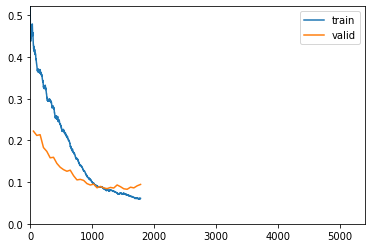

Better model found at epoch 3 with f1_score value: 0.8211382113821138.
Better model found at epoch 5 with f1_score value: 0.8232118758434548.
Better model found at epoch 6 with f1_score value: 0.8248275862068966.
Better model found at epoch 7 with f1_score value: 0.8269230769230769.
Better model found at epoch 8 with f1_score value: 0.8382749326145552.
Better model found at epoch 10 with f1_score value: 0.8406961178045516.
Better model found at epoch 11 with f1_score value: 0.8421052631578948.
Better model found at epoch 12 with f1_score value: 0.8470906630581867.
Better model found at epoch 13 with f1_score value: 0.853816300129366.
Better model found at epoch 14 with f1_score value: 0.8556149732620321.
Better model found at epoch 19 with f1_score value: 0.863013698630137.
Better model found at epoch 27 with f1_score value: 0.8699186991869919.
Better model found at epoch 33 with f1_score value: 0.8770491803278688.
No improvement since epoch 28: early stopping


In [16]:
learn.fine_tune(100,base_lr=1e-3,freeze_epochs=3)

In [17]:
dfTest = pd.read_csv('../testSample.csv')

In [18]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [19]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=128,num_workers=0)

In [21]:
learn.dls = dlsTest

In [22]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9530261669953977.


(#6) [0.08311153203248978,0.870769202709198,0.9159953970080552,0.8164102564102564,0.8633405639913232,0.9530261669953977]

# 384

In [6]:
import torch
torch.cuda.set_device(1)
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs384wwf',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('resnetrs224wwf')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003981071640737355)

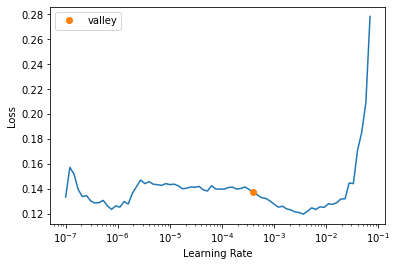

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.134358,0.125473,0.820513,0.900641,0.720513,0.800570,0.910322,01:36


Better model found at epoch 0 with f1_score value: 0.8005698005698006.


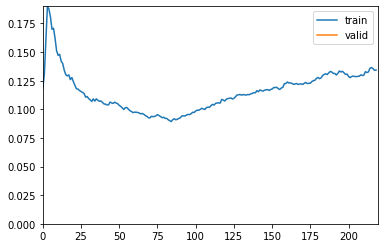

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.090035,0.082429,0.869231,0.913793,0.815385,0.861789,0.943264,01:52
1,0.080924,0.077781,0.878205,0.913165,0.835897,0.872825,0.948938,01:51
2,0.083689,0.077497,0.880769,0.940653,0.812821,0.872077,0.951824,01:51
3,0.082064,0.075229,0.896154,0.945245,0.841026,0.890095,0.954168,01:52
4,0.078546,0.076489,0.891026,0.913279,0.864103,0.888011,0.949057,01:51
5,0.069698,0.075142,0.885897,0.919220,0.846154,0.881175,0.953531,01:51
6,0.073993,0.078582,0.888462,0.949555,0.820513,0.880330,0.956256,01:52
7,0.068722,0.080695,0.879487,0.948485,0.802564,0.869444,0.953961,01:51
8,0.064554,0.074832,0.891026,0.886076,0.897436,0.891720,0.951923,01:51
9,0.063177,0.085940,0.888462,0.954955,0.815385,0.879668,0.955894,01:51


Better model found at epoch 0 with f1_score value: 0.8617886178861788.


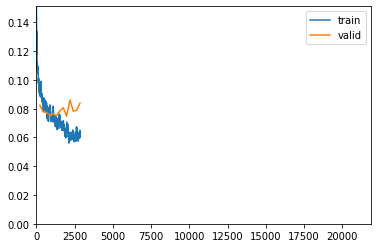

Better model found at epoch 1 with f1_score value: 0.8728246318607764.
Better model found at epoch 3 with f1_score value: 0.8900949796472185.
Better model found at epoch 8 with f1_score value: 0.8917197452229298.
Better model found at epoch 10 with f1_score value: 0.8924731182795698.
Better model found at epoch 13 with f1_score value: 0.9066666666666667.
No improvement since epoch 8: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9592915187376725.


(#6) [0.07671383768320084,0.8805128335952759,0.9159192825112108,0.837948717948718,0.8752008569898232,0.9592915187376725]

# 512

In [7]:
import torch
torch.cuda.set_device(1)
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs512wwf',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [11]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [12]:
learn.load('resnetrs384wwf')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=7.943282253108919e-05)

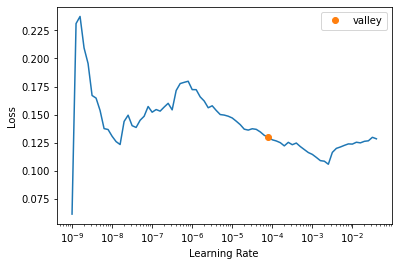

In [15]:
learn.lr_find(start_lr=1e-09)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.095257,0.079316,0.879487,0.915730,0.835897,0.873995,0.949389,03:15


Better model found at epoch 0 with f1_score value: 0.873994638069705.


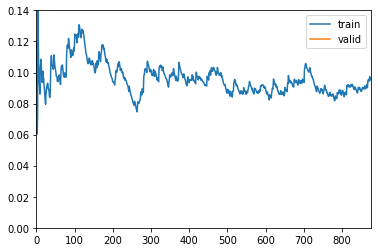

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.088825,0.074094,0.888462,0.915068,0.856410,0.884768,0.953320,03:59
1,0.089530,0.072411,0.884615,0.916667,0.846154,0.880000,0.955822,03:54
2,0.086851,0.076595,0.882051,0.925714,0.830769,0.875676,0.955191,03:53
3,0.066211,0.075829,0.888462,0.934097,0.835897,0.882273,0.954750,03:53
4,0.091372,0.074574,0.883333,0.923513,0.835897,0.877524,0.955302,03:53
5,0.079353,0.072455,0.888462,0.929178,0.841026,0.882907,0.957344,03:53
6,0.077460,0.072099,0.889744,0.913043,0.861538,0.886544,0.956236,03:53
7,0.077569,0.070378,0.883333,0.911846,0.848718,0.879150,0.958557,03:53
8,0.078636,0.078829,0.880769,0.954128,0.800000,0.870293,0.956719,03:55
9,0.066827,0.072138,0.893590,0.927577,0.853846,0.889186,0.957972,03:59


Better model found at epoch 0 with f1_score value: 0.8847682119205298.


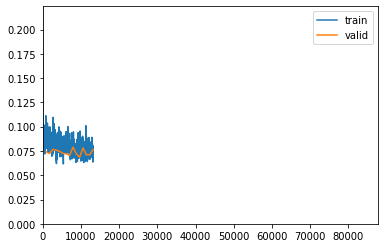

Better model found at epoch 6 with f1_score value: 0.8865435356200527.
Better model found at epoch 9 with f1_score value: 0.8891855807743659.
Better model found at epoch 10 with f1_score value: 0.8969072164948454.
Better model found at epoch 12 with f1_score value: 0.9016189290161893.
No improvement since epoch 10: early stopping


In [16]:
learn.fine_tune(100,base_lr=3e-4)

In [17]:
dfTest = pd.read_csv('../testSample.csv')

In [18]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [19]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [21]:
learn.dls = dlsTest

In [22]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9625351742274819.


(#6) [0.07059400528669357,0.8928205370903015,0.8747553816046967,0.916923076923077,0.8953430145217828,0.9625351742274819]

In [19]:
preds,y=learn.tta()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [21]:
import numpy as np

In [22]:
np.argmax(preds,axis=1)

tensor([0, 0, 0,  ..., 1, 1, 0])

In [23]:
f1_score(np.argmax(preds,axis=1),y)

0.9001040582726326

In [24]:
precision_score(np.argmax(preds,axis=1),y)

0.8871794871794871

In [25]:
recall_score(np.argmax(preds,axis=1),y)

0.9134107708553326